## Автоматизация поиска аномалий

### Цель:
- автоматизировать поиск аномалий для метрик: активные пользователи в ленте / мессенджере, просмотры, лайки, CTR, количество отправленных сообщений;

### Задачи:
- Выгрузить и обработать данные;
- Создать алгоритм определения аномального отклонения метрик;
- отправлять короткое сообщение об обнаруженной аномалии в чат telegram с помощью бота;

### Решение:
- Автоматизацию будем настраивать с помощью связки GitLab и Airflow, код будет запускаться каждые 15 минут;
- Алгоритм поиска аномалий - сравнение текущего значения метрики с величиной, которая рассчитывается на основании нижних и верхних квантилей 5 предыдущих периодов, 5 периодов вокруг текущего времени предыдущего дня и аналогичных периодов недельной давности.


### Код:

In [2]:
import pandas as pd
import pandahouse as ph
import seaborn as sns
import matplotlib.pyplot as plt
import telegram
import io
from airflow import DAG
from datetime import datetime, timedelta, date
from airflow.decorators import dag, task
from IPython.display import Image

default_args = {
    'owner': 'd-tsykarev-13',
    'depends_on_past': False,
    'retries': 2,
    'retry_delay': timedelta(minutes=5),
    'start_date': datetime(2022, 12, 15)
}

schedule_interval = '* /15 * * * *'


@dag(default_args=default_args, schedule_interval=schedule_interval, catchup=False, tags=['d-tsykarev'])
def feed_messanger_alerts_tsykarev():
    ### Читаем данные
    @task
    def extract():
        connection = {'host': 'https://clickhouse.lab.karpov.courses',
                              'database':'simulator_20221120',
                              'user':'student', 
                              'password':'dpo_python_2020'
                             }

        query = '''
        SELECT *
        FROM (
            SELECT 
                toStartOfFifteenMinutes(time) as ts,
                uniq(user_id) as feed_users,
                sum(action = 'view') as views,
                sum(action = 'like') as likes,
                formatDateTime(ts, '%R') as hm,
                likes/views as ctr
            FROM {db}.feed_actions 
            WHERE ts >=  today() - INTERVAL 11 day - INTERVAL 4 HOUR and ts < toStartOfFifteenMinutes(now())
            GROUP BY ts) AS feed_data
            JOIN
            (
            SELECT 
                toStartOfFifteenMinutes(time) as ts,
                uniq(user_id) as messager_users,
                formatDateTime(ts, '%R') as hm,
                count(user_id) as sent_messages
            FROM {db}.message_actions 
            WHERE ts >=  today() - INTERVAL 11 day - INTERVAL 4 HOUR and ts < toStartOfFifteenMinutes(now())
            GROUP BY ts
            ) AS message_data
            ON feed_data.ts = message_data.ts
        ORDER BY ts
        '''

        df = ph.read_clickhouse(query, connection=connection)
        return df
    
    @task
    def transform_load(df):
        ## Функция рассчета верхней и нижней границ условий алерта, проверка выполнения условий
        def alert_condition(df, metric, intevals_today = 5, intervals_prvs_days = 9, a = 3):
            ## Функция для проверки проверки предыдущих выбросов и их замены
            def rmv_sharp_shifts(row, max_q, min_q, metric='feed_users'):
                if row[metric+'_grow'] > max_q:
                    return row[metric+'_shifted']*max_q
                elif row[metric+'_grow'] < min_q:
                    return row[metric+'_shifted']*min_q
                else:
                    return row[metric]

            ## Блок с устранением предыдущих выбросов, т.к. 
            ## частично в прогнозировании будущих значений бубут участовать значения метрик прошлых дней
            df[metric+'_shifted'] = df[metric].shift(1)
            df[metric+'_grow'] = df[metric]/df[metric+'_shifted']
            max_q = df[metric+'_grow'].quantile(0.975)
            min_q = df[metric+'_grow'].quantile(0.025)
            df['feed_users'] = df.apply(lambda x: rmv_sharp_shifts(x, max_q, min_q, metric=metric), axis=1)

            ## Подсчет квантилей за предыдущий день
            df['yst_25'] = df[metric].rolling(5, center=True).quantile(0.25).shift(96)
            df['yst_75'] = df[metric].rolling(5, center=True).quantile(0.75).shift(96)

            ## Подсчет квантилей того же дня недели неделю назад
            df['byst_25'] = df[metric].rolling(5, center=True).quantile(0.25).shift(672)
            df['byst_75'] = df[metric].rolling(5, center=True).quantile(0.75).shift(672)

            ## Подсчет кванителей текущего дня
            df['today_25'] = df[metric].shift(1).rolling(5).quantile(0.25)
            df['today_75'] = df[metric].shift(1).rolling(5).quantile(0.75)

            ## Расчет финальных квантилей(основной вес имеют данные текущего дня)
            df['q_25'] = df['today_25']*0.7 + df['yst_25']*0.15 + df['byst_25']*0.15
            df['q_75'] = df['today_75']*0.7 + df['yst_75']*0.15 + df['byst_75']*0.15
            df['q_diff'] = df['q_75'] - df['q_25']

            ## Расчет верхней и нижней границ
            df['low'] = df['q_25'] - df['q_diff']*a
            df['low'] = df['low'].rolling(5, center=True, min_periods=1).mean()
            df['up'] = df['q_75'] + df['q_diff']*a
            df['up'] = df['up'].rolling(5, center=True, min_periods=1).mean()

            ## Если последнее значение выше или ниже предельных значений
            alert = False
            if df[metric].iloc[-1] > df['up'].iloc[-1] or df[metric].iloc[-1] < df['low'].iloc[-1]:
                alert = True

            return metric, alert, df, 'Метрика {metric}\nТекущее значение: {current_value}'.format(metric=metric, 
                                                                                 current_value=df[metric].iloc[-1]
                                                                                 )
        ## Применение проверки выполнения условий ко всем метрикам и отправка сообщений ботом
        def check_all_metrics(data = df):
            ### Подключаемся к боту
            my_token = '5817720440:AAGEIaTOdG1oZkbVURVBsLNMMzcfV8Vr814'
            bot = telegram.Bot(token=my_token)
            chat_id = 563750798

            ## Проверка выполнения условий алерта
            metrics = ['feed_users', 'views', 'likes', 'ctr', 'messager_users', 'sent_messages']
            for metric in metrics:
                metric, alert, df, msg = alert_condition(data, metric)
                if alert == True:
                        bot.sendMessage(chat_id=chat_id, text=msg)

                        ## Фомриуем график
                        ax = sns.lineplot(data = df[df['ts'] >= df['ts'].max() - timedelta(days=1)], x = 'hm', y = metric)
                        sns.lineplot(data = df[df['ts'] >= df['ts'].max() - timedelta(days=1)], x = 'hm', y = 'up', linestyle='--')
                        sns.lineplot(data = df[df['ts'] >= df['ts'].max() - timedelta(days=1)], x = 'hm', y = 'low', linestyle='--')
                        for ind, label in enumerate(ax.get_xticklabels()):
                            if ind % 15 == 0:
                                label.set_visible(True)
                            else:
                                label.set_visible(False)
                        ax.set_title(metric)

                        ## Отправка графиков
                        plot_object = io.BytesIO()
                        plt.savefig(plot_object)
                        plot_object.seek(0)
                        plot_object.name = 'feed_data_plot.png'
                        plt.close()
                        bot.sendPhoto(chat_id=chat_id, photo=plot_object)

        check_all_metrics(data = df)
                    
    df = extract()
    transform_load(df)
    
feed_messanger_alerts_tsykarev = feed_messanger_alerts_tsykarev()

### Примеры отправляемых графиков

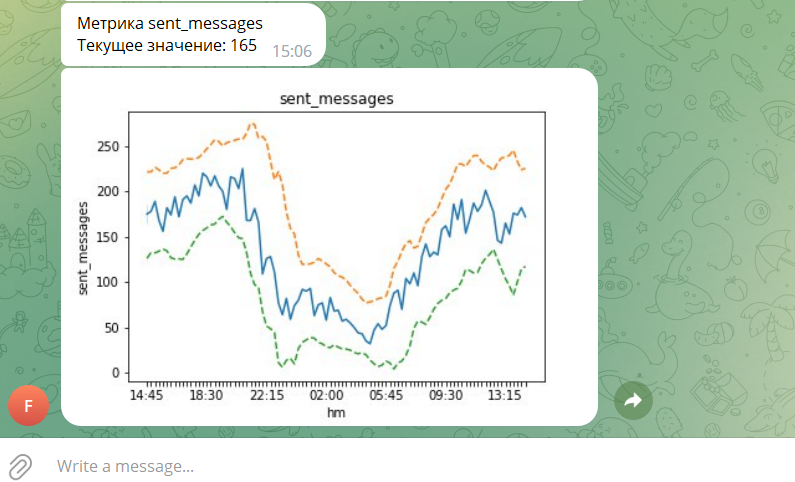

In [5]:
display(Image("Screenshot_12.png"))